# Sentiment Analysis & Generate eMFDs Moral Scores

## Sentiment Analysis

In [1]:
# import libarary

import warnings
import string
import numpy as np
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

!pip install twython 

!pip install textblob
from textblob import TextBlob

from sklearn import cluster

import pandas as pd
from pandas.api.types import is_numeric_dtype

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brinxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/brinxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/brinxu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brinxu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


You should consider upgrading via the '/Users/brinxu/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [8]:
covid_data = pd.read_csv('covid_data_final.csv')

In [11]:
# lenghth of the column
len(covid_data.Message)

84385

In [12]:
covid_data.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'Likes at Posting', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Is Video Owner?', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'URL', 'Message', 'Link', 'Link Text',
       'Description',
       'Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'LNC_category', 'ï»¿Page Name', 'Video Share Status', 'Video Length',
       'Final Link', 'Image Text', 'Sponsor Id', 'Sponsor Name',
       'Sponsor Category',
       'Overperforming Score (weighted  â  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'covid'],
      dtype='object')

In [10]:
# Let's create our feature vector as Kmeans works with numerical values only
# thus we need to convert our text data into numeric features in some way which should 
# prove usful to our learning algorithm and it can easily find pattern in it.
# So, i will be using polarity score of the extracted adjectives as our feature

def create_polarity_vector(all_adjectives):
    # NLTK Vader sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    #Taking compound score as one feature, (compund score = -ve indicates negative sentiments)
    #(compund score = +ve indicates positive sentiments, ie compound value is normalization b/w +ve and -ve)
    # give value of -1 1 depending postive or negative. 
    # The polarity score is a float within the range [-1.0, 1.0]. 
    # Convert words into vector form
    # vectorizing is to encode text as intergers to create feature vectors
    # feature vector is a an n-dimensional vector of numerical features that represent some object (document turned matrix)
    feature_vector=[1 if sid.polarity_scores(i)['compound']>=0 else -1 for i in all_adjectives]
    
    return feature_vector

# function to read text file
def polarity_sets_file(input_file):
    with open(input_file, 'r') as f:
        input_text = f.read()
        return input_text

# function to extract all adjectives from text document
def extract_adjectives(text):
    # tokenize text
    tokenized_text= nltk.word_tokenize(text)
    # tag token into grammatical categorization (i.e., no) 
    tagged_text = nltk.pos_tag(tokenized_text)
    # extract only objective items from the text
    all_adjectives = list({i[0] for i in tagged_text if i[1] == 'JJ'})
    return all_adjectives


#Alternate way to clean text
#To clean text we can use regex in python 
# import re
'''
def cleanResume(cleanText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return cleanText
    
'''
# Cleaning up text 
def clean_text(text):    
    #stopword removal 
    stop_word=list(stopwords.words('english'))
    # join the text after removing the stopwords
    toke=list(text.split(' '))
    text = ' '.join([i for i in toke if i not in stop_word])
    
    #punctutaion removal
    t_lator=str.maketrans('','',string.punctuation)
    text=text.translate(t_lator)
    #digit removal
    remove_digits = str.maketrans('', '', string.digits)
    text = text.translate(remove_digits)    
    
    #removing special symbol
    for i in '“”—':
        text = text.replace(i, ' ')
        
    return text
import time


# remove warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    PN = []
    # covid_data = covid_data.sample(100)
    # combine the two list and loop together
    for i,text in enumerate(covid_data.Message):
      if i%100 == 0:
        print('{} message processed'.format(i))
      try:
        # Reading our file
        # text = polarity_sets_file('test.txt')
        # cleaning our text data
        text = clean_text(text)
        # Getting adjectieves from our document
        adjectives = extract_adjectives(text)
        # Preparing our feature vector
        features = create_polarity_vector(adjectives)
        # Making clusters using KMeans
        # convert it to vector form
        feature_ = np.array(features).reshape(-1,1)
        # Divide text into 2 clusters 
        kmeans = cluster.KMeans(n_clusters=2)
        # prvide data to the model
        kmeans.fit(feature_)
        # give prediction value of 0/1
        labels = kmeans.predict(feature_)

        # Identifying positive and negative terms
        type1_terms,type2_terms = [], []
        # assignment 0/1 
        for i,j in zip(adjectives,labels):
            if j == 0 :
                type1_terms.append(i)
            else:
                type2_terms.append(i)
        if len(type1_terms) > len(type2_terms):
          PN.append('N')
        else:
          PN.append('P')

      except:
        PN.append(np.nan)
        continue

0 message processed
100 message processed
200 message processed
300 message processed
400 message processed
500 message processed
600 message processed
700 message processed
800 message processed
900 message processed
1000 message processed
1100 message processed
1200 message processed
1300 message processed
1400 message processed
1500 message processed
1600 message processed
1700 message processed
1800 message processed
1900 message processed
2000 message processed
2100 message processed
2200 message processed
2300 message processed
2400 message processed
2500 message processed
2600 message processed
2700 message processed
2800 message processed
2900 message processed
3000 message processed
3100 message processed
3200 message processed
3300 message processed
3400 message processed
3500 message processed
3600 message processed
3700 message processed
3800 message processed
3900 message processed
4000 message processed
4100 message processed
4200 message processed
4300 message processed


34700 message processed
34800 message processed
34900 message processed
35000 message processed
35100 message processed
35200 message processed
35300 message processed
35400 message processed
35500 message processed
35600 message processed
35700 message processed
35800 message processed
35900 message processed
36000 message processed
36100 message processed
36200 message processed
36300 message processed
36400 message processed
36500 message processed
36600 message processed
36700 message processed
36800 message processed
36900 message processed
37000 message processed
37100 message processed
37200 message processed
37300 message processed
37400 message processed
37500 message processed
37600 message processed
37700 message processed
37800 message processed
37900 message processed
38000 message processed
38100 message processed
38200 message processed
38300 message processed
38400 message processed
38500 message processed
38600 message processed
38700 message processed
38800 message pr

68900 message processed
69000 message processed
69100 message processed
69200 message processed
69300 message processed
69400 message processed
69500 message processed
69600 message processed
69700 message processed
69800 message processed
69900 message processed
70000 message processed
70100 message processed
70200 message processed
70300 message processed
70400 message processed
70500 message processed
70600 message processed
70700 message processed
70800 message processed
70900 message processed
71000 message processed
71100 message processed
71200 message processed
71300 message processed
71400 message processed
71500 message processed
71600 message processed
71700 message processed
71800 message processed
71900 message processed
72000 message processed
72100 message processed
72200 message processed
72300 message processed
72400 message processed
72500 message processed
72600 message processed
72700 message processed
72800 message processed
72900 message processed
73000 message pr

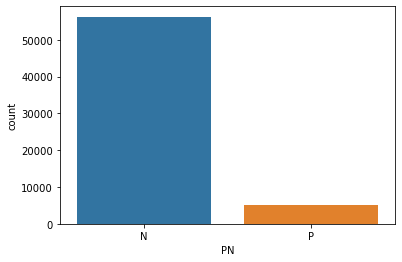

In [15]:
"""
Postive/negative posts results
"""
# make a new column 
covid_data['PN'] = PN
# PN = postive or negative
ax = sns.countplot(x="PN", data=covid_data)
# already mentioned about countplot alternate

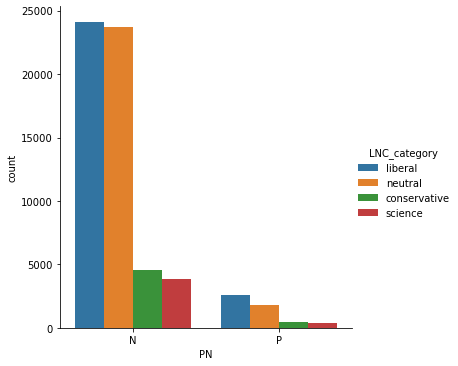

In [17]:
"""
Relation between Postive/negative posts and journal type.
"""
sns.catplot(x="PN", hue="LNC_category", kind="count", data=covid_data)

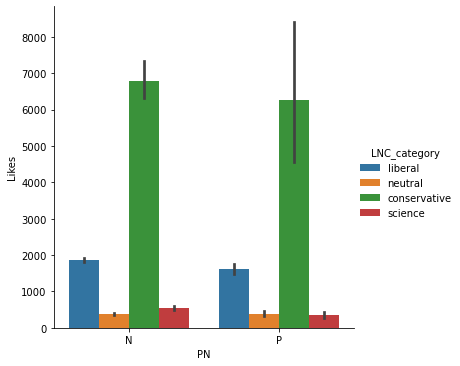

In [18]:
sns.catplot(x="PN",y="Likes", hue="LNC_category", kind="bar", data=covid_data)

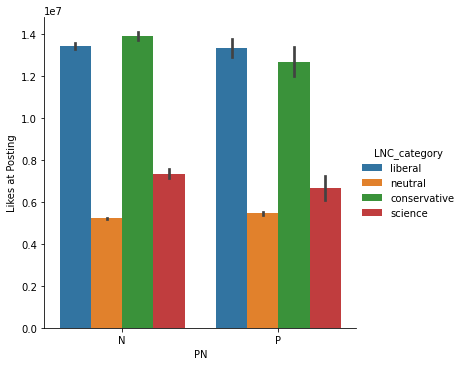

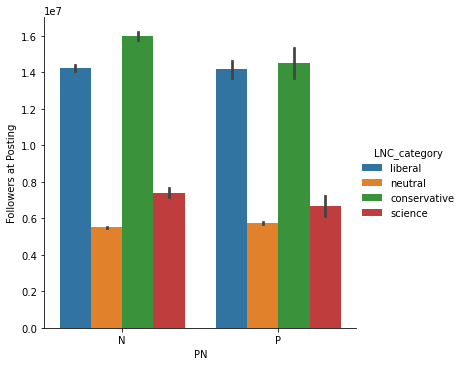

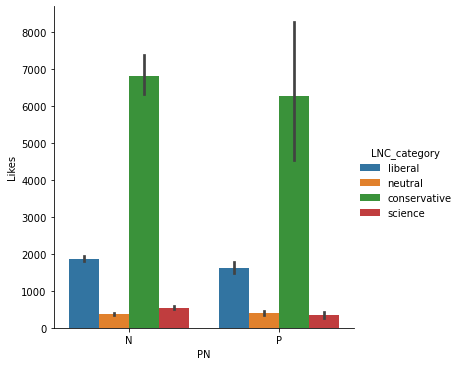

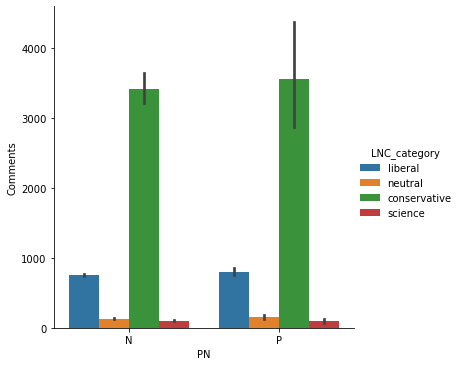

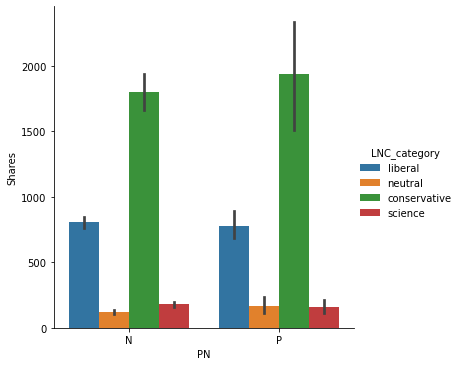

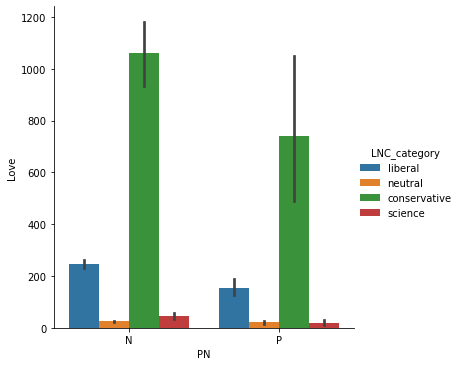

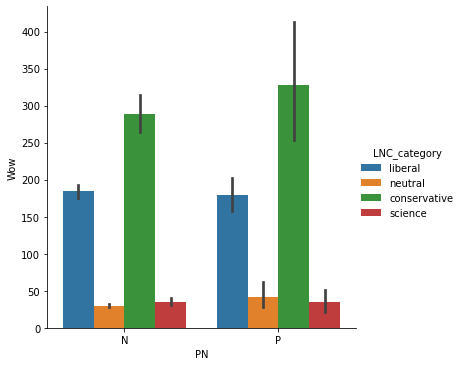

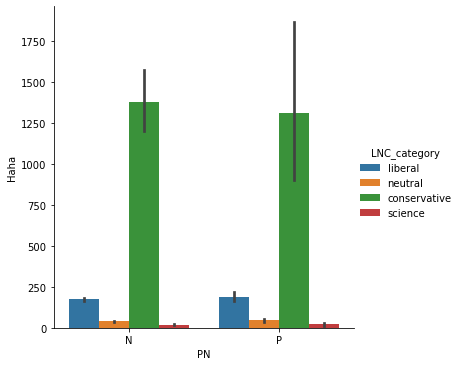

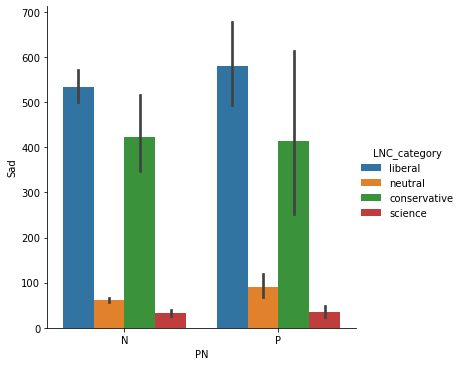

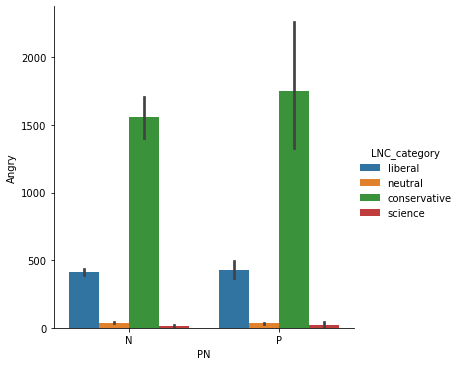

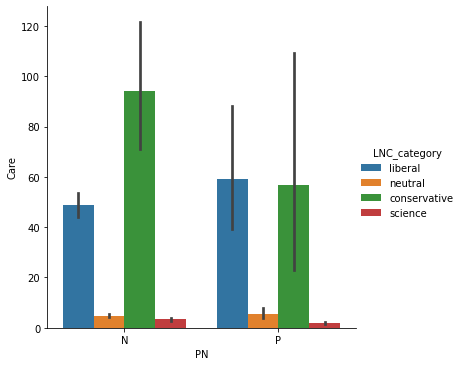

In [21]:
for col in ['Likes at Posting','Followers at Posting','Total Interactions','Likes','Comments','Shares','Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care']:
    if is_numeric_dtype(covid_data[col]):
        sns.catplot(x="PN",y=col, hue="LNC_category", kind="bar", data=covid_data)     

## Generate eMFDs Moral Scores

In [22]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [23]:
# make a dataframe from the "message" column
template_input = pd.DataFrame(data=covid_data.Message.values)
template_input.head()

,0
0,A pair of US senators are asking the Biden adm...
1,The stark disparity between low and high vacci...
2,US Surgeon General Dr. Vivek Murthy says he is...
3,Kim Jong Un fired several senior officials who...
4,"In many ways, the pandemic was a perfect storm..."


In [24]:
!pip install https://github.com/medianeuroscience/emfdscore/archive/master.zip

     - 6.5 MB 1.8 MB/s
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/Users/brinxu/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [25]:
from emfdscore.scoring import score_docs 

num_docs = len(template_input)

# use the pre-defined value of the dictionary 
DICT_TYPE = 'emfd'
PROB_MAP = 'all'
SCORE_METHOD = 'bow'
OUT_METRICS = 'sentiment'
OUT_CSV_PATH = 'all-sent.csv'

# provide input to the pretrained eMFDs model
df = score_docs(template_input,DICT_TYPE,PROB_MAP,SCORE_METHOD,OUT_METRICS,num_docs)
df.to_csv(OUT_CSV_PATH, index=False)

Processed: 84385 100% |❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤| Elapsed Time: 0:04:25 Time:  0:04:25


In [26]:
covid_data.shape

(84385, 45)

In [27]:
# combine all data together
DF_FINAL = pd.concat([covid_data.reset_index(drop=True),df.reset_index(drop=True)], axis=1)
DF_FINAL.head(2)

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,...,authority_p,sanctity_p,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,moral_nonmoral_ratio,f_var,sent_var
0,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34563652.0,38358192.0,2021-06-30 13:00:28 EDT,...,0.139355,0.085406,-0.121268,-0.095777,0.006735,-0.070749,-0.175241,0.777778,0.000574,0.004499
1,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34563652.0,38358192.0,2021-06-30 09:27:09 EDT,...,0.083956,0.093256,-0.120624,-0.086392,-0.081137,-0.065666,-0.057119,0.777778,0.000388,0.000599


In [29]:
DF_FINAL.to_csv('final.csv', index=False)

In [ ]:
DF_FINAL = pd.read_csv('final.csv')